In [2]:
#%matplotlib notebook
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# tools for applying bundle adjustment to a temporal sequence of satellite images
import bundle_adjust.ba_timeseries as ba_timeseries

from bundle_adjust import data_loader as loader
from PIL import Image
import glob

# Display and interface settings (just for the notebook interface)
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

### Load scene

#############################################################
Loading scene from...
    - images_dir: /home/anger/for_roger/L1B



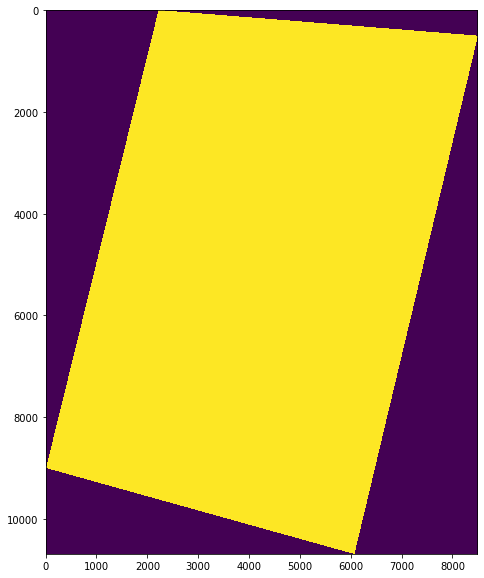

Found 1 different dates in the scene timeline

Total images in timeline: 101

The AOI covers a total of 61.63 squared km:
#############################################################




Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [3]:
mine_loader = {'images_dir': '/home/anger/for_roger/L1B',
               's2p_configs_dir': '/home/anger/for_roger/s2p',
               'output_dir': 'exp/mine',
               'aoi_geojson': None,
               'compute_aoi_masks': True,
               'use_aoi_masks_to_equalize_crops': False}
    
scene = ba_timeseries.Scene(mine_loader)
scene.display_aoi()

### Copy  pc3dr output as rasterized dsms equivalent to the BA ones

In [9]:
t_id = scene.timeline[0]['id']
rec4D_dir =  '/home/rogermm14/sat-bundleadjust/exp/mine/ba_global/4D'
pc3dr_in_dir = '/home/anger/for_roger/reg'
s2p_dir = os.path.join(rec4D_dir, 's2p/{}'.format(t_id))

dsm_resolution = 0.8

In [5]:
s2p_dsm_fnames = loader.load_s2p_dsm_fnames_from_dir(s2p_dir)

for idx, s2p_dsm_fn in enumerate(s2p_dsm_fnames):
    path_to_ply_files = os.path.dirname(s2p_dsm_fn).replace(s2p_dir, pc3dr_in_dir)
    ply_fnames = glob.glob(os.path.join(path_to_ply_files, '**/*.ply'), recursive=True)
    if len(ply_fnames) == 0:
        continue
    dst_dsm_fname = s2p_dsm_fn.replace('/s2p/', '/pc3dr/')
    os.makedirs(os.path.dirname(dst_dsm_fname), exist_ok=True)
    #dsm_resolution = float(loader.json2dict(s2p_dsm_fn.replace('/dsm.tif', '/config.json'))['dsm_resolution'])
    args = [path_to_ply_files, dst_dsm_fname, dsm_resolution]
    cmd = "plyflatten $(find {} -name 'cloud.ply') {} --resolution {}".format(*args)
    os.system(cmd)
    
    print('\rRasterizing {} dsm / {}'.format(idx+1, len(s2p_dsm_fnames)), end='\r')

In [7]:
complete_dsm_fname = os.path.join(rec4D_dir, 'dsms/{}_pc3dr.tif'.format(t_id))
args = [pc3dr_in_dir, complete_dsm_fname, dsm_resolution]
cmd = "plyflatten $(find {} -name 'cloud.ply') {} --resolution {}".format(*args)
os.system(cmd)

print('{} successfully created'.format(complete_dsm_fname))

/home/rogermm14/sat-bundleadjust/exp/mine/ba_global/4D/dsms/20190128_204710_pc3dr.tif successfully created


### Compare std pc3dr with std BA

In [10]:
from bundle_adjust import ba_metrics

pc3dr_dsms_fnames = loader.load_s2p_dsm_fnames_from_dir(s2p_dir.replace('/s2p/', '/pc3dr/'))
std_per_date_dir = os.path.join(rec4D_dir, 'metrics_pc3dr/std_per_date')

ba_metrics.compute_std_for_specific_date_from_tiles(complete_dsm_fname, pc3dr_dsms_fnames,
                                                    output_dir=std_per_date_dir)


###################################################################################
Computing std for specific date...
  - complete_dsm_fname: /home/rogermm14/sat-bundleadjust/exp/mine/ba_global/4D/dsms/20190128_204710_pc3dr.tif
  - tile_size: 500
###################################################################################


Clipping dsms...
116 dsms / 116
Done!

616 tiles / 616
Done!



/home/rogermm14/sat-bundleadjust/exp/mine/ba_global/4D/metrics_pc3dr/std_per_date/20190128_204710_pc3dr_std.tif 
median std: 0.162 / average std: 6.610


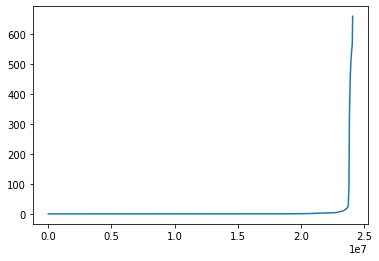

In [16]:
#
# pc3dr
#

std_fname = os.path.join(rec4D_dir, 'metrics_pc3dr/std_per_date/{}_pc3dr_std.tif'.format(t_id))

im = np.array(Image.open(std_fname)).flatten()
im = np.sort(im[~np.isnan(im)])

print('{} \nmedian std: {:.3f} / average std: {:.3f}'.format(std_fname, np.median(im), np.mean(im)))
plt.plot(im)
plt.show()


/home/rogermm14/sat-bundleadjust/exp/mine/ba_global/4D/std_ba.tif 
median std: 0.250 / average std: 0.362


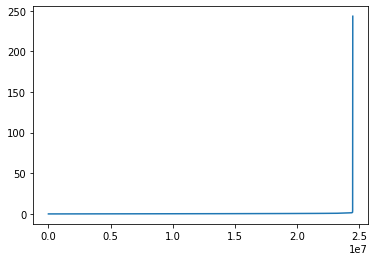

In [19]:
#
# bundle adjustment 
#
      
std_fname = os.path.join(rec4D_dir, 'std_ba.tif')
    
im = np.array(Image.open(std_fname)).flatten()
im = np.sort(im[~np.isnan(im)])
      
print('{} \nmedian std: {:.3f} / average std: {:.3f}'.format(std_fname, np.median(im), np.mean(im)))
plt.plot(im)
plt.show()


/home/rogermm14/sat-bundleadjust/exp/mine/ba_global/4D/metrics/std_per_date/20190128_204710_std.tif 
median std: 0.322 / average std: 0.432


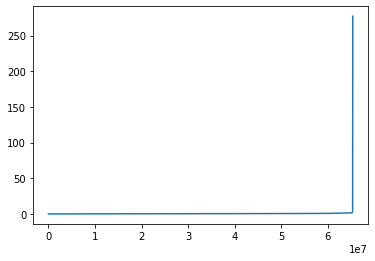

In [21]:
std_fname = os.path.join(rec4D_dir, 'metrics/std_per_date/{}_std.tif'.format(t_id))

im = np.array(Image.open(std_fname)).flatten()
im = np.sort(im[~np.isnan(im)])
      
print('{} \nmedian std: {:.3f} / average std: {:.3f}'.format(std_fname, np.median(im), np.mean(im)))
plt.plot(im)
plt.show()